In [2]:
import json
import logging
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import bif
from custom.functions import InvokeWMLModel
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.base import BaseTransformer
from iotfunctions.bif import EntityDataGenerator
from custom import settings
import datetime as dt

import pandas as pd
import numpy as np

from watson_machine_learning_client import WatsonMachineLearningAPIClient
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.pipeline import Pipeline
import sklearn
import time

/Users/kkbankol@us.ibm.com/projects/watson-analytics-dashboard/env/lib/python3.7/site-packages/iotfunctions/bif.py:1995: UserWarning: IoTCalcSettings is deprecated. Use entity type constants instead of a metadata provider to set entity type properties
  warnings.warn(('IoTCalcSettings is deprecated. Use entity type constants'

2020-05-18 08:54:26,819 - root - INFO - 
Logging Set To: DEBUG


Loading WML Environment Variables
Environment Variables Loaded Successfully


In [5]:
# set Monitor credentials here
credentials = {}
db = Database(credentials = credentials)
db_schema = None #  set if you are not using the default
entity_name = "Equipment"
df = db.read_table(table_name=entity_name, schema=db_schema)



2020-05-18 09:20:31,190 - iotfunctions.db - INFO - 
Connection string for SqlAlchemy => db2): db2+ibm_db://bluadmin:YzkzZjg4MGVlOGVi@dashdb-enterprise-yp-dal12-126.services.dal.bluemix.net:50000/BLUDB;

2020-05-18 09:20:31,190 - iotfunctions.db - INFO - 
Connection string for SqlAlchemy => db2): db2+ibm_db://bluadmin:YzkzZjg4MGVlOGVi@dashdb-enterprise-yp-dal12-126.services.dal.bluemix.net:50000/BLUDB;

2020-05-18 09:20:31,195 - iotfunctions.db - DEBUG - 
created a CosClient object

2020-05-18 09:20:31,966 - iotfunctions.db - DEBUG - 
Db connection established

2020-05-18 09:20:32,754 - iotfunctions.db - DEBUG - 
http request successful. status 200
/Users/kkbankol@us.ibm.com/projects/watson-analytics-dashboard/env/lib/python3.7/site-packages/sqlalchemy/engine/reflection.py:919: SAWarning: index key 'sqlnotapplicable' was not located in columns for table 'Equipment'
  "columns for table '%s'" % (flavor, c, table_name)


In [16]:
df.head()

,deviceid,evt_timestamp,devicetype,logicalinterface_id,eventtype,format,updated_utc,drvn_p1,maintenance_status_x,mainteancne_status_y,...,compressor_in_y,asset_id,compressor_out_x,drvr_rpm,compressor_out_y,drvn_flow,run_status_x,drvn_t1,run_status_y,anomaly_score
0,73001,2020-03-29 15:55:42.529,Equipment,,tp,,2020-03-29 16:00:42.571,0.322422,-2,0,...,-0.153476,dt,0.411088,1.016982,1.119419,0.770955,0,1.907953,1,0.0
1,73003,2020-03-29 16:00:42.529,Equipment,,ev,,2020-03-29 16:00:42.571,-0.624873,0,0,...,0.431678,is,-0.596250,-1.000191,0.721079,0.389489,1,0.335828,0,0.0
2,73008,2020-03-28 17:55:56.878,Equipment,,te,,2020-03-29 17:55:58.667,51.048978,0,0,...,0.506799,as,0.074470,1.675125,-0.437089,-1.141689,0,20.894523,0,0.0
3,73007,2020-03-28 18:00:56.878,Equipment,,ep,,2020-03-29 17:55:58.667,50.141485,0,0,...,-0.029483,ae,1.726746,-1.174888,1.243611,-0.668326,0,20.901785,0,0.0
4,73004,2020-03-28 18:05:56.878,Equipment,,yy,,2020-03-29 17:55:58.667,48.571544,0,1,...,1.403546,ei,-0.399540,-1.328274,-0.723412,1.735435,0,20.954194,-1,0.0


In [24]:
## Data Scientist Section
## Build model beforehand using data
## Build custom model locally (user custom data science notebook will go here)


# Define input columns (Replace with your asset columns here)
columns = ['drvn_t1', 'drvn_t2', 'drvn_p1', 'drvn_p2', 'drvn_flow']
columns.sort()

# Define entities (add ids of anomalous entities)
entities = ["73000", "73001"]

# Filter dataframe to selected entities / input columns
s_df = pd.DataFrame(columns=columns)
for e in entities:
    selected_entity_data = df[columns].loc[ df['deviceid'] == e, :][columns]
    s_df = s_df.append( selected_entity_data, ignore_index=True)
    
# s_df = df[columns].loc[df['deviceid'] == "73001", :][columns]

# Convert dataframe to 2d Array (WML needs array for sending JSON)
rows = [list(r) for i,r in s_df.iterrows()]

# Create a model (using IsolationForest here with default settings)
clf = IsolationForest()

# Place classifier in a sklearn "pipeline"
pipeline = Pipeline( steps = [ ( "classifier", clf ) ] )

# Fit data to model pipeline
pipeline.fit(rows)

# Test model
results = pipeline.predict(rows)

# Place model results into 'anomaly_score' column
s_df.loc[: ,'anomaly_score'] = results
print(s_df.head())

73000
73001
         drvn_flow    drvn_p1    drvn_p2    drvn_t1     drvn_t2
0         0.929509  50.780520   0.108464  22.290654   -0.437272
1         0.609233  49.365699  -0.043723  21.864707   -1.408430
2        -0.362722  49.496586   1.345326  21.986428    0.736088
3         0.136566  47.820473   0.570917  22.401832   -0.566285
4        -1.578993  50.248643  -0.335741  22.317393   -1.002465
...            ...        ...        ...        ...         ...
17107  2523.881780  63.684747  81.596082  79.605934  175.133054
17108  2523.946799  63.858130  81.818229  79.822663  175.609858
17109  2523.798717  63.463244  81.312282  79.329055  174.523922
17110  2523.684584  63.158889  80.922327  78.948612  173.686946
17111  2523.545127  62.787005  80.445851  78.483757  172.664265

[17112 rows x 5 columns]


/Users/kkbankol@us.ibm.com/projects/watson-analytics-dashboard/env/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


   drvn_flow    drvn_p1   drvn_p2    drvn_t1   drvn_t2  anomaly_score
0   0.929509  50.780520  0.108464  22.290654 -0.437272             -1
1   0.609233  49.365699 -0.043723  21.864707 -1.408430             -1
2  -0.362722  49.496586  1.345326  21.986428  0.736088             -1
3   0.136566  47.820473  0.570917  22.401832 -0.566285             -1
4  -1.578993  50.248643 -0.335741  22.317393 -1.002465             -1


In [23]:
# Print breakdown of anomalous values vs non-anomalous
from collections import Counter
print(Counter(results))


Counter({1: 15435, -1: 1679})


In [269]:
s_df.iloc[turbine1.index]

,drvn_flow,drvn_p1,drvn_p2,drvn_t1,drvn_t2,anomaly_score
1,105000.000000,15000.000000,15000.000000,20.421572,20.421572,-1
3,41.380231,5.172529,5.172529,20.690116,20.690116,1
5,62.070347,7.758793,7.758793,23.276380,23.276380,1
7,64.240689,6.424069,6.424069,25.696276,25.696276,1
9,96.361034,9.636103,9.636103,28.908310,28.908310,1
...,...,...,...,...,...,...
1989,2524.797648,62.947876,80.115479,57.225342,131.618287,1
1991,17500.000000,45000.000000,60000.000000,57.225342,143.063355,-1
1993,2513.372454,35.659877,45.689218,44.574847,98.064663,1
1995,2523.401795,56.832930,71.876940,50.146703,120.352086,1



2020-05-18 09:44:37,606 - matplotlib.pyplot - DEBUG - 
Loaded backend module://ipykernel.pylab.backend_inline version unknown.

2020-05-18 09:44:37,610 - matplotlib.pyplot - DEBUG - 
Loaded backend module://ipykernel.pylab.backend_inline version unknown.

2020-05-18 09:44:37,940 - matplotlib.font_manager - DEBUG - 
findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.

2020-05-18 09:44:37,942 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05

2020-05-18 09:44:37,944 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 1.05

2020-05-18 09:44:37,945 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal bold normal>) = 10.335

2020-05-18 09:44:37,946 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'cmb10' (cmb10.ttf)


2020-05-18 09:44:38,059 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'STIXIntegralsUpSm' (STIXIntUpSmReg.otf) normal normal regular normal>) = 10.05

2020-05-18 09:44:38,062 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'Noto Sans Old South Arabian' (NotoSansOldSouthArabian-Regular.ttf) normal normal regular normal>) = 10.05

2020-05-18 09:44:38,064 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'Noto Sans Yi' (NotoSansYi-Regular.ttf) normal normal regular normal>) = 10.05

2020-05-18 09:44:38,066 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'Noto Sans Rejang' (NotoSansRejang-Regular.ttf) normal normal regular normal>) = 10.05

2020-05-18 09:44:38,067 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W8.ttc) normal normal 700 normal>) = 10.335

2020-05-18 09:44:38,070 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'IBM Plex Sans Condensed' (IBMPlexSansCondensed-ExtraLightItalic.ttf) 


2020-05-18 09:44:38,346 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'Noto Sans PhagsPa' (NotoSansPhagsPa-Regular.ttf) normal normal regular normal>) = 10.05

2020-05-18 09:44:38,353 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'Noto Serif Balinese' (NotoSerifBalinese-Regular.ttf) normal normal regular normal>) = 10.05

2020-05-18 09:44:38,359 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'IBM Plex Devanagari' (IBMPlexDevanagari-Regular.ttf) normal normal 400 normal>) = 10.05

2020-05-18 09:44:38,365 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'Noto Sans Linear B' (NotoSansLinearB-Regular.ttf) normal normal regular normal>) = 10.05

2020-05-18 09:44:38,367 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'Noto Sans Sundanese' (NotoSansSundanese-Regular.ttf) normal normal regular normal>) = 10.05

2020-05-18 09:44:38,369 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'IBM Plex Sans' (IBMPlexSans-ExtraLightIta


2020-05-18 09:44:38,461 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'Khmer Sangam MN' (Khmer Sangam MN.ttf) normal normal 400 normal>) = 10.05

2020-05-18 09:44:38,462 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'IBM Plex Sans Condensed' (IBMPlexSansCondensed-MediumItalic.ttf) italic normal medium condensed>) = 11.344999999999999

2020-05-18 09:44:38,464 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font '.SF NS Rounded' (SFNSRounded.ttf) normal normal 400 normal>) = 10.05

2020-05-18 09:44:38,465 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'Geeza Pro' (GeezaPro.ttc) normal normal regular normal>) = 10.05

2020-05-18 09:44:38,467 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'Ayuthaya' (Ayuthaya.ttf) normal normal 400 normal>) = 10.05

2020-05-18 09:44:38,468 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'Gill Sans' (GillSans.ttc) normal normal 400 normal>) = 10.05

2020-05-18 09:44:38,470 - matplotlib.font


2020-05-18 09:44:38,617 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'Silom' (Silom.ttf) normal normal 400 normal>) = 10.05

2020-05-18 09:44:38,620 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'IBM Plex Sans' (IBMPlexSans-SemiBoldItalic.ttf) italic normal semibold normal>) = 11.24

2020-05-18 09:44:38,623 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'IBM Plex Devanagari' (IBMPlexDevanagari-Thin.ttf) normal normal 400 normal>) = 10.05

2020-05-18 09:44:38,625 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'Chalkboard' (Chalkboard.ttc) normal normal 400 normal>) = 10.05

2020-05-18 09:44:38,629 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'Cochin' (Cochin.ttc) normal normal 400 normal>) = 10.05

2020-05-18 09:44:38,630 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'IBM Plex Sans Thai Looped' (IBMPlexSansThaiLooped-Text.ttf) normal normal 400 normal>) = 10.05

2020-05-18 09:44:38,631 - matplotlib.font_manag


2020-05-18 09:44:38,728 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'Apple SD Gothic Neo' (AppleSDGothicNeo.ttc) normal normal regular normal>) = 10.05

2020-05-18 09:44:38,730 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'IBM Plex Arabic' (IBMPlexArabic-Text.ttf) normal normal 400 normal>) = 10.05

2020-05-18 09:44:38,732 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'STIXGeneral' (STIXGeneral.otf) normal normal regular normal>) = 10.05

2020-05-18 09:44:38,734 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'Courier New' (Courier New Italic.ttf) italic normal 400 normal>) = 11.05

2020-05-18 09:44:38,735 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'Noto Sans Osmanya' (NotoSansOsmanya-Regular.ttf) normal normal regular normal>) = 10.05

2020-05-18 09:44:38,738 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'Kannada MN' (Kannada MN.ttc) normal normal 400 normal>) = 10.05

2020-05-18 09:44:38,740 - matplotl


2020-05-18 09:44:38,847 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'Damascus' (Damascus.ttc) normal normal regular normal>) = 10.05

2020-05-18 09:44:38,849 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'IBM Plex Devanagari' (IBMPlexDevanagari-Light.ttf) normal normal light normal>) = 10.24

2020-05-18 09:44:38,851 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'IBM Plex Mono' (IBMPlexMono-TextItalic.ttf) italic normal 400 normal>) = 11.05

2020-05-18 09:44:38,854 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Medium.otf) normal normal medium condensed>) = 10.344999999999999

2020-05-18 09:44:38,856 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'IBM Plex Mono' (IBMPlexMono-ExtraLightItalic.ttf) italic normal light normal>) = 11.24

2020-05-18 09:44:38,858 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'Noto Sans Gothic' (NotoSansGothic-Regular.ttf) normal normal reg


2020-05-18 09:44:39,130 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'STIXVariants' (STIXVarBol.otf) normal normal bold normal>) = 10.335

2020-05-18 09:44:39,132 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'Noto Sans Samaritan' (NotoSansSamaritan-Regular.ttf) normal normal regular normal>) = 10.05

2020-05-18 09:44:39,134 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'Copperplate' (Copperplate.ttc) normal normal 400 normal>) = 10.05

2020-05-18 09:44:39,137 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Black.otf) normal normal black condensed>) = 10.725

2020-05-18 09:44:39,140 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'Tamil Sangam MN' (Tamil Sangam MN.ttc) normal normal 400 normal>) = 10.05

2020-05-18 09:44:39,142 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'Telugu Sangam MN' (Telugu Sangam MN.ttc) normal normal 400 normal>) = 10.05

2020-05-18 09


2020-05-18 09:44:39,235 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'Noto Sans Coptic' (NotoSansCoptic-Regular.ttf) normal normal regular normal>) = 10.05

2020-05-18 09:44:39,237 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'Bodoni Ornaments' (Bodoni Ornaments.ttf) normal normal 400 normal>) = 10.05

2020-05-18 09:44:39,239 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'IBM Plex Sans Condensed' (IBMPlexSansCondensed-ThinItalic.ttf) italic normal 400 condensed>) = 11.25

2020-05-18 09:44:39,242 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'Noto Sans NKo' (NotoSansNKo-Regular.ttf) normal normal regular normal>) = 10.05

2020-05-18 09:44:39,243 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'Verdana' (Verdana Italic.ttf) italic normal 400 normal>) = 4.6863636363636365

2020-05-18 09:44:39,245 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'Bangla Sangam MN' (Bangla Sangam MN.ttc) normal normal 400 normal>) =


2020-05-18 09:44:39,382 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'Gujarati Sangam MN' (Gujarati Sangam MN.ttc) normal normal 400 normal>) = 10.05

2020-05-18 09:44:39,385 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font '.Arabic UI Text' (ArabicUIText.ttc) normal normal regular normal>) = 10.05

2020-05-18 09:44:39,386 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Ultralight.otf) normal normal ultralight condensed>) = 10.535

2020-05-18 09:44:39,389 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'IBM Plex Serif' (IBMPlexSerif-Italic.ttf) italic normal 400 normal>) = 11.05

2020-05-18 09:44:39,391 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'Papyrus' (Papyrus.ttc) normal normal 400 condensed>) = 10.25

2020-05-18 09:44:39,393 - matplotlib.font_manager - DEBUG - 
findfont: score(<Font 'Mishafi Gold' (Mishafi Gold.ttf) normal normal regular normal>) = 10.05

2020-05-18 09:

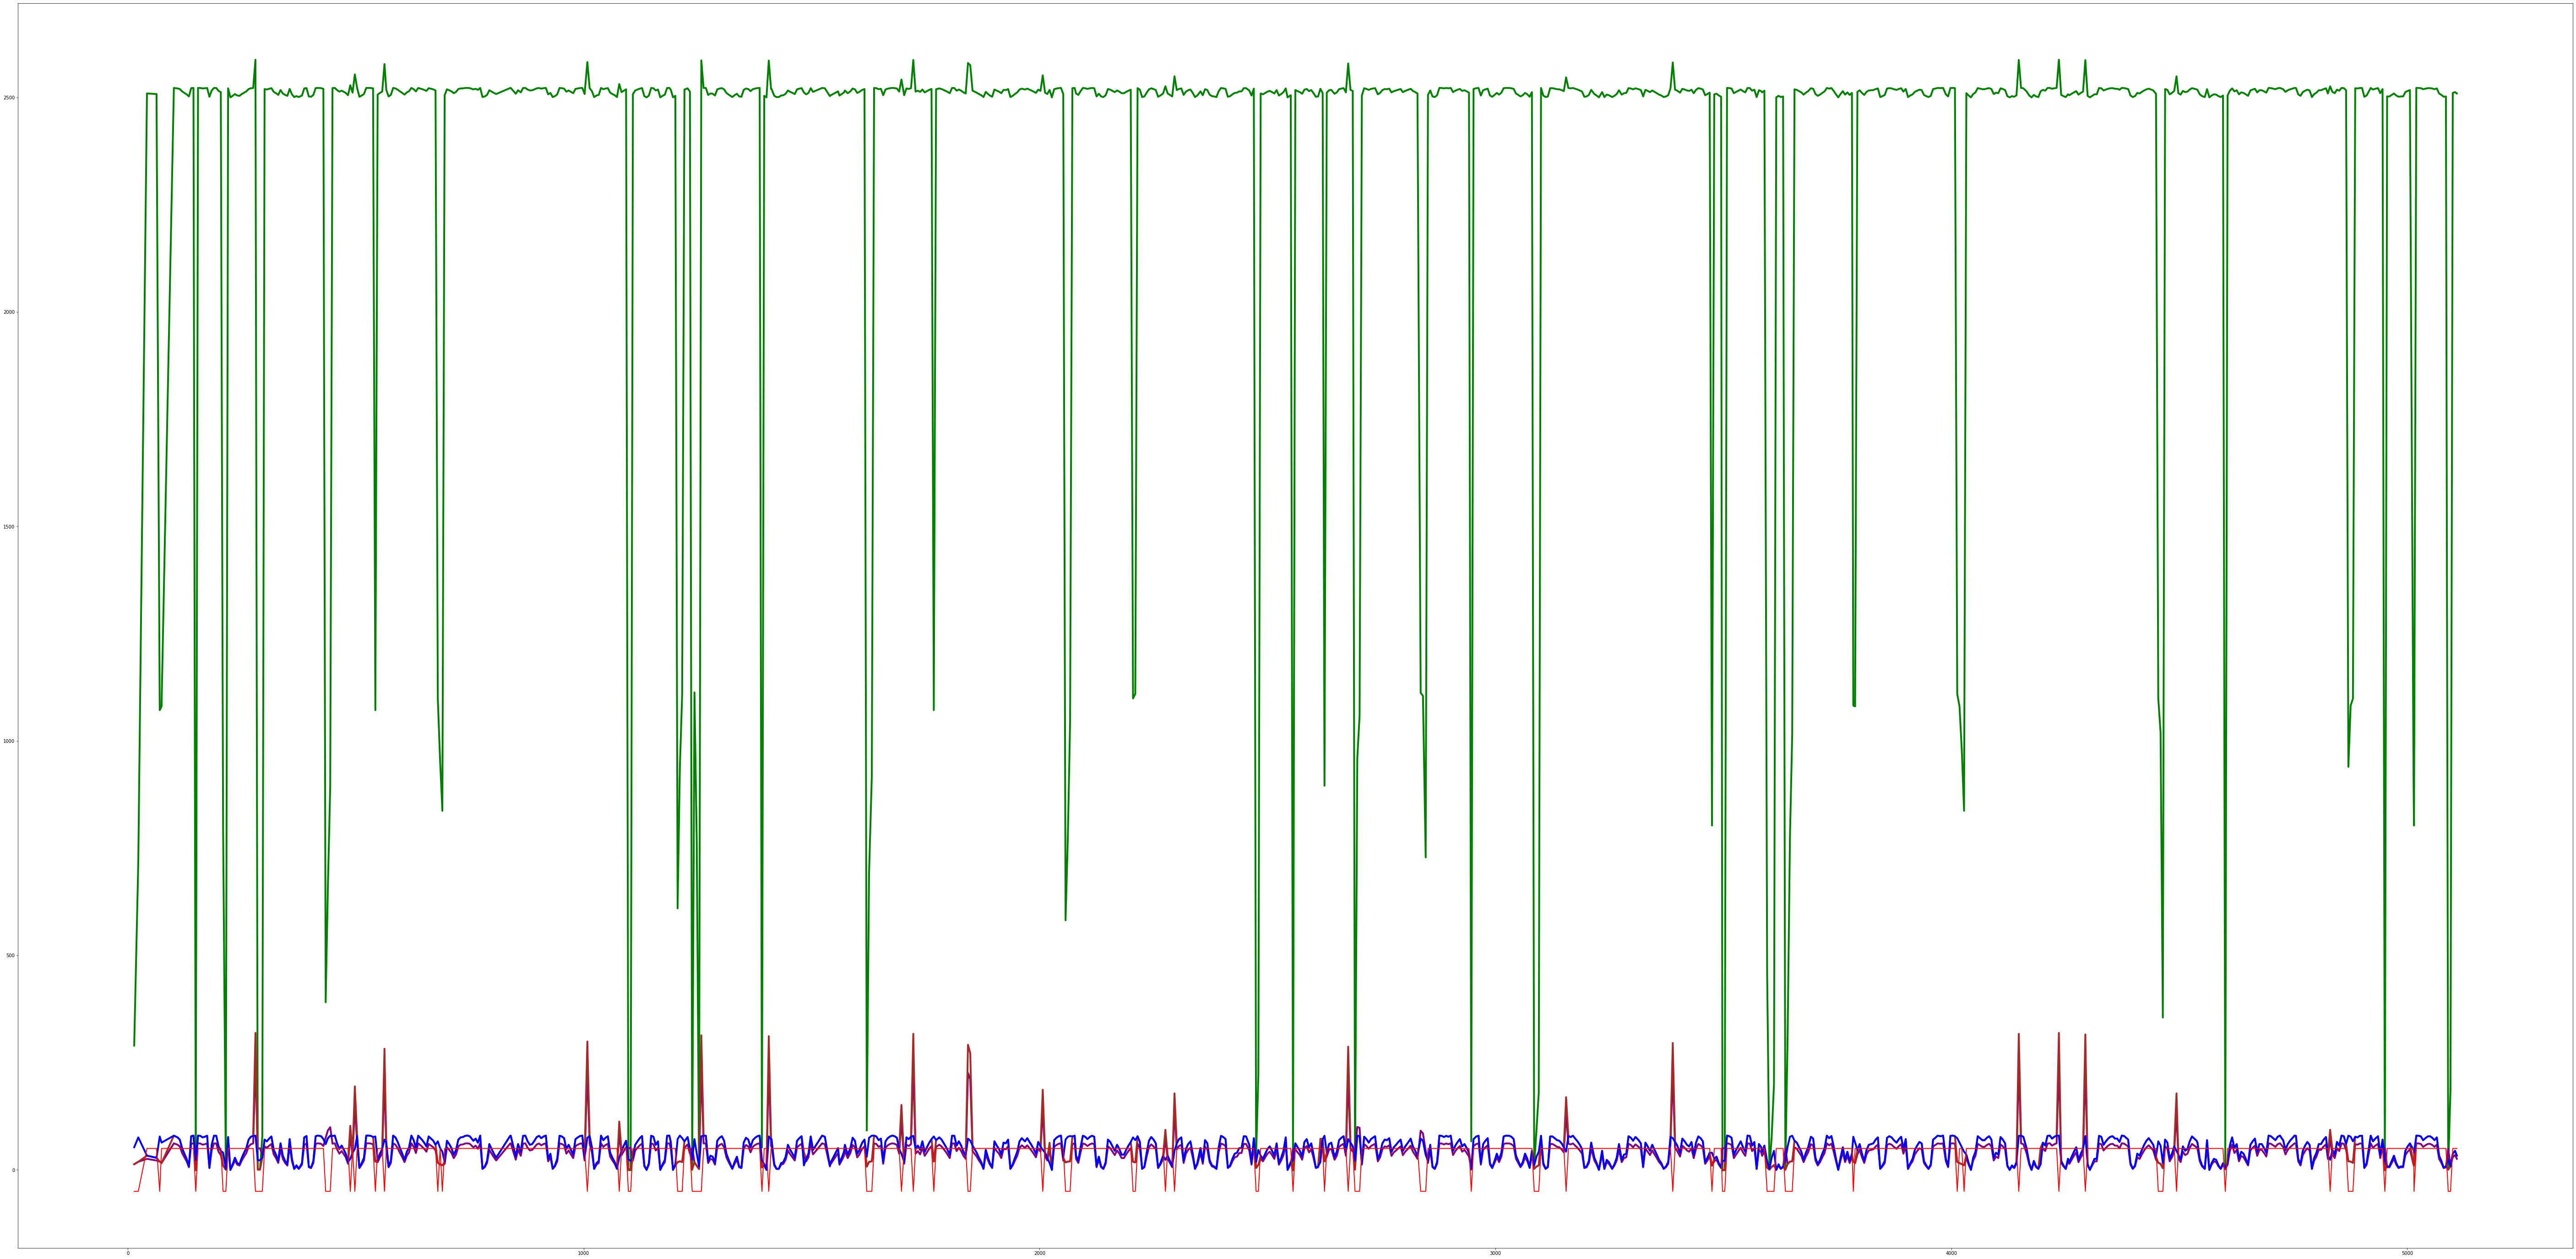

In [25]:
# Plot results
# note - devices 73002 73003 are normal. 73001, 73000 have more anomalies


import matplotlib.pyplot as plt
turbine1 = df.loc[df['deviceid'] == "73000", :][0:1000]
# s_df.loc[: ,'anomaly_score'] = results
# plt.plot(s_df.iloc[turbine1.index]['pressure'], color='blue', label='drvn_t1')
plt.figure(figsize=(100, 50))

plt.plot(s_df.iloc[turbine1.index]['drvn_flow'], color='green', label='drvn_p1', linewidth=4)
plt.plot(s_df.iloc[turbine1.index]['drvn_p1'], color='purple', label='drvn_flow', linewidth=4)
plt.plot(s_df.iloc[turbine1.index]['drvn_p2'], color='brown', label='drvn_flow', linewidth=4)
plt.plot(s_df.iloc[turbine1.index]['drvn_t1'], color='blue', label='drvn_flow', linewidth=4)
# plt.plot(s_df.iloc[turbine1.index]['step'], color='yellow', label='drvn_flow', linewidth=4)
plt.plot(s_df.iloc[turbine1.index]['anomaly_score'] * 50, color='red', label='anomaly_score', linewidth=2)
plt.savefig('/tmp/plotout.png')

In [27]:
## publish model

# IMPORTANT, once this is done, take note of the WATSON_ML_DEPLOYMENT_ID, which will be printed in 

# create WML client
wml_creds_path = '/Users/kkbankol@us.ibm.com/projects/maximo_anomaly/wml_credentials.json'
wml_credentials = json.loads(open(wml_creds_path).read())
client = WatsonMachineLearningAPIClient( wml_credentials )


sk_version = sklearn.__version__
metadata = {
    client.repository.ModelMetaNames.FRAMEWORK_VERSION: 'scikit-learn',
    client.repository.ModelMetaNames.FRAMEWORK_VERSION: sk_version,
    client.repository.ModelMetaNames.NAME: 'anomaly_model',
    client.repository.ModelMetaNames.RUNTIME_NAME: 'python',
    client.repository.ModelMetaNames.RUNTIME_VERSION: '3.6'
}

# upload pipeline 
model_details_inmem = client.repository.store_model( pipeline, meta_props=metadata)
model_id_inmem = model_details_inmem["metadata"]["guid"]
deployment_details_inmem = client.deployments.create( artifact_uid=model_id_inmem, name="anomaly_model" )
deployment_id = deployment_details_inmem["metadata"]["guid"]
model_endpoint_url_inmem = client.deployments.get_scoring_url( deployment_details_inmem )
print("model invocation endpoint: " + model_endpoint_url_inmem)
print("Place below line in .env file like so")
print("WATSON_ML_DEPLOYMENT_ID=" + deployment_id) # TODO, need to confirm notebook will reload .env file. Or just change from .env to mem



2020-05-06 10:07:47,701 - ModelCollection - DEBUG - 
Creating a new scikit pipeline model: anomaly_model

2020-05-06 10:07:49,206 - watson_machine_learning_client.libs.repo.swagger_client.rest - DEBUG - 
response body: {"metadata":{"guid":"482f74aa-60ba-4332-a658-3acd12f0f138","url":"https://us-south.ml.cloud.ibm.com/v3/ml_assets/models/482f74aa-60ba-4332-a658-3acd12f0f138","created_at":"2020-05-06T17:07:48.038Z"},"entity":{"name":"anomaly_model","model_url":"/v3/ml_assets/models/482f74aa-60ba-4332-a658-3acd12f0f138","framework":{"name":"scikit-learn","version":"0.20","runtimes":[{"name":"python","version":"3.6"}]},"model_version":{"url":"https://us-south.ml.cloud.ibm.com/v3/ml_assets/models/482f74aa-60ba-4332-a658-3acd12f0f138/versions/a317882b-9801-46cd-9b58-20a4468f94c8","guid":"a317882b-9801-46cd-9b58-20a4468f94c8","content_status":{"state":"no_content"},"hyper_parameters":[],"content_url":"https://us-south.ml.cloud.ibm.com/v3/ml_assets/models/482f74aa-60ba-4332-a658-3acd12f0f138/



#######################################################################################

Synchronous deployment creation for uid: '482f74aa-60ba-4332-a658-3acd12f0f138' started

#######################################################################################


INITIALIZING
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='c4f31a07-9d81-4f55-b58a-6e9aa2f81326'
------------------------------------------------------------------------------------------------


model invocation endpoint: https://us-south.ml.cloud.ibm.com/v3/wml_instances/96665647-9805-45e0-baec-e6484dc74628/deployments/c4f31a07-9d81-4f55-b58a-6e9aa2f81326/online
Place below line in .env file like so
WATSON_ML_DEPLOYMENT_ID=c4f31a07-9d81-4f55-b58a-6e9aa2f81326


In [93]:
wml_creds_path = '/Users/kkbankol@us.ibm.com/projects/maximo_anomaly/wml_credentials.json'
wml_credentials = json.loads(open(wml_creds_path).read())
client = WatsonMachineLearningAPIClient( wml_credentials )

client.deployments.list()

------------------------------------  -------------  ------  --------------  ------------------------  -----------------  -------------
GUID                                  NAME           TYPE    STATE           CREATED                   FRAMEWORK          ARTIFACT TYPE
6b716b52-7c7d-4316-a8fd-f042b57c2491  anomaly_model  online  DEPLOY_SUCCESS  2020-04-03T12:32:11.604Z  scikit-learn-0.20  model
6515b909-f485-45f4-a97c-4047b9d64e94  anomaly_model  online  DEPLOY_SUCCESS  2020-04-03T12:24:43.677Z  scikit-learn-0.20  model
69373af1-8fd2-4650-ae35-2d5ebb01d4ae  anomaly_model  online  DEPLOY_SUCCESS  2020-04-03T07:02:31.270Z  scikit-learn-0.20  model
7fe4fe5b-8b59-43cf-b6fa-b0e9a1bdfcb5  anomaly_model  online  DEPLOY_SUCCESS  2020-04-03T07:00:51.860Z  scikit-learn-0.20  model
ca28c2d9-868a-4e14-b910-cc676c3af03f  anomaly_model  online  DEPLOY_SUCCESS  2020-04-03T06:57:55.605Z  scikit-learn-0.20  model
b97ba5d2-2571-466c-8e0f-34a964f835e0  anomaly_model  online  DEPLOY_SUCCESS  2020-04-03T

In [ ]:
from custom.functions import CustomMLModel
db.register_functions([CustomMLModel], force_preinstall=True)

In [ ]:
# test function in monitor

WATSON_ML_ENDPOINT = settings.WATSON_ML_ENDPOINT
WATSON_ML_INSTANCE_ID = settings.WATSON_ML_INSTANCE_ID
WATSON_ML_APIKEY = settings.WATSON_ML_APIKEY
WATSON_ML_DEPLOYMENT_ID = settings.WATSON_ML_DEPLOYMENT_ID

IAM_UID = settings.IAM_UID
IAM_PASSWORD = settings.IAM_PASSWORD

INPUT_COLUMNS = settings.INPUT_COLUMNS or []
if INPUT_COLUMNS and (len(INPUT_COLUMNS) > 0):
    INPUT_COLUMNS = INPUT_COLUMNS.replace(' ', '').split(',')
else:
    INPUT_COLUMNS = []

INPUT_COLUMNS = columns
WATSON_ML_DEPLOYMENT_ID=deployment_id

entity = EntityType(entity_name, db,
                # following columns can be dynamically generated based on meters associated with each asset
                IsolationForestModel(
                                wml_endpoint=WATSON_ML_ENDPOINT,
                                instance_id=WATSON_ML_INSTANCE_ID,
                                deployment_id=WATSON_ML_DEPLOYMENT_ID,
                                apikey=WATSON_ML_APIKEY,
                                input_columns=INPUT_COLUMNS,
                                output_item = 'anomaly_score_output'),
                **{
                  '_timestamp' : 'evt_timestamp',
                  '_db_schema' : db_schema}
)
entity.exec_local_pipeline()
